In [1]:
# github.com/JaeHyung-Kim/Generate_Jordan.git

# References
# https://crystalcube.co.kr/192 남녀구분 ( cnn)
# https://neurowhai.tistory.com/158 data generator. 회전및 확대축소로 데이터셋 증대
# https://neurowhai.tistory.com/273 포켓몬 빌런(dcgan)

# Load the Drive helper and mount 

from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from PIL import Image

images = os.listdir("/content/drive/My Drive/JordanDataset100x100")

for i, name in enumerate(images):
    png = Image.open("/content/drive/My Drive/JordanDataset100x100/" + name)
    png.load()
    
    background = Image.new("RGB", png.size, (255, 255, 255))
    background.paste(png, mask=png.split()[3])
    
    background.thumbnail((32,32), Image.ANTIALIAS)
    background.save("/content/drive/My Drive/JordanRGB/" + str(i) + ".jpg", 'JPEG', quality=80)

In [3]:
import os.path
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import keras.backend as K
import matplotlib.pyplot as plt
from PIL import Image

K.set_image_data_format('channels_last')

In [57]:
class Gan:
  def __init__(self, img_data):
    img_size = img_data.shape[1]
    channel = img_data.shape[3] if len(img_data.shape) >=4 else 1
    
    self.img_data = img_data
    self.input_shape = (img_size, img_size, channel)
    
    self.img_rows = img_size
    self.img_cols = img_size
    self.channel = channel
    self.noise_size = 100
    
    self.create_d()
    self.create_g()
    
    optimizer = Adam(lr=0.00003)
    self.D.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    optimizer = Adam(lr=0.0007)
    self.D.trainable = False
    self.AM = Sequential()
    self.AM.add(self.G)
    self.AM.add(self.D)
    self.AM.compile(loss='binary_crossentropy', optimizer=optimizer)
    
  def create_d(self):
    self.D = Sequential()
    depth = 64
    dropout = 0.2
    self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=self.input_shape, padding='same'))
    self.D.add(LeakyReLU(alpha=0.2))
    self.D.add(Dropout(dropout))
    self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
    self.D.add(LeakyReLU(alpha=0.2))
    self.D.add(Dropout(dropout))
    self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
    self.D.add(LeakyReLU(alpha=0.2))
    self.D.add(Dropout(dropout))
    self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
    self.D.add(LeakyReLU(alpha=0.2))
    self.D.add(Dropout(dropout))
    self.D.add(Flatten())
    self.D.add(Dense(1))
    self.D.add(Activation('sigmoid'))
    self.D.summary()
    return self.D
  
  def create_g(self):
    self.G = Sequential()
    dropout = 0.2
    depth = 64+64+64+64
    dim = 8
    self.G.add(Dense(dim*dim*depth, input_dim=self.noise_size))
    self.G.add(BatchNormalization(momentum=0.9))
    self.G.add(Activation('relu'))
    self.G.add(Reshape((dim, dim, depth))) 
    self.G.add(Dropout(dropout))
    self.G.add(UpSampling2D())
    self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
    self.G.add(BatchNormalization(momentum=0.9))
    self.G.add(Activation('relu'))
    self.G.add(UpSampling2D())
    self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
    self.G.add(BatchNormalization(momentum=0.9))
    self.G.add(Activation('relu'))
    self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same')) 
    self.G.add(BatchNormalization(momentum=0.9))
    self.G.add(Activation('relu'))
    self.G.add(Conv2DTranspose(self.channel, 5, padding='same'))
    self.G.add(Activation('sigmoid')) 
    self.G.summary()
    return self.G
  
  def train(self, batch_size=10):
    images_train = self.img_data[np.random.randint(0, self.img_data.shape[0], size=batch_size), :, :, :]

    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.noise_size])
    images_fake = self.G.predict(noise)
  
  
    x = np.concatenate((images_train, images_fake))
    y = np.ones([2*batch_size, 1])
    y[batch_size:, :] = 0
    self.D.trainable = True
    d_loss = self.D.train_on_batch(x, y)
  
    y = np.ones([batch_size, 1])
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.noise_size])
    self.D.trainable = False
    a_loss = self.AM.train_on_batch(noise, y)
  
    return d_loss, a_loss, images_fake
  


In [58]:
class JordanData():
  def __init__(self):
    img_data_list = []
    images = os.listdir("/content/drive/My Drive/JordanRGB/")
    
    for path in images:
      img = Image.open("/content/drive/My Drive/JordanRGB/" + path)
      img_data_list.append([np.array(img).astype('float32')])
      
    self.x_train = np.vstack(img_data_list) / 255.0
    print(self.x_train.shape)
      

In [ ]:
dataset = JordanData()
x_train = dataset.x_train

gan = Gan(x_train)


epochs = 1000
sample_size = 10
batch_size = 10
train_per_epoch = x_train.shape[0] // batch_size

Epoch: 49, D Loss: 0.6203591525554657, AM Loss: 0.6979950964450836


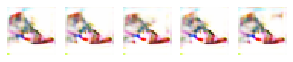

Epoch: 99, D Loss: 0.585224986076355, AM Loss: 0.789584219455719


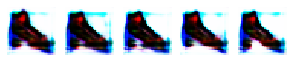

KeyboardInterrupt: ignored

In [61]:
for epoch in range(0, epochs):
  total_d_loss = 0.0
  total_a_loss = 0.0
  imgs = None
  
  for batch in range(0, train_per_epoch):
    d_loss, a_loss, t_imgs = gan.train(batch_size)
    total_d_loss += d_loss
    total_a_loss += a_loss
    if imgs is None:
      imgs = t_imgs
      
  if epoch % 50 == 49 or epoch == epochs - 1:
    total_d_loss /= train_per_epoch
    total_a_loss /= train_per_epoch
    print("Epoch: {}, D Loss: {}, AM Loss: {}"
          .format(epoch, total_d_loss, total_a_loss))
    
    fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1)) 
    for i in range(sample_size): 
      ax[i].set_axis_off()
      ax[i].imshow(imgs[i].reshape((gan.img_rows, gan.img_cols, gan.channel)),
                    interpolation='nearest');
      
    plt.show()
    plt.close(fig);
